In [1]:
# install.packages("GGally")
library(tidyverse)
library(caret)
library(ggplot2)
library(GGally)


The downloaded binary packages are in
	/var/folders/mn/w1m_3v8j6ys7d3x9hm7v2ykr0000gn/T//RtmpS2NWbd/downloaded_packages


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.4
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘GGally’


The following object is masked from ‘package:dplyr’:

    nasa




# Predicting Tennis Match Winners

# Introduction

The US Open grand slam tennis tournament has an estimated total prize money pool of USD $50.4 million. This puts it in line with high-value tournaments such as the MLB World Series and the PGA FedEx Cup (source: pledgesports.org). With such a high potential payoff, there is much incentive for competitive tennis athletes and coaches to understand the player attributes that contribute to tournament success. 

This project will study the data of tennis match results collected for the top 500 tennis players. The purpose of the study is to determine whether certain attributes contribute to greater competitive success by analyzing player and match information. The dataset contains results from nearly 7,000 matches and includes the winner and loser heights, playing hands, countries of origin, ages, match times and other information (source: https://github.com/JeffSackmann/tennis_atp). 

# Preliminary Exploratory Data Analysis

minutes,hand,age,height,aces,result
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<fct>
58,L,26.39836,190,2,l
66,L,26.95688,185,6,w
116,R,22.34908,NA,1,l
NA,U,16.36140,NA,3,l
137,R,34.41205,183,0,l
NA,R,32.09582,185,NA,l


Warning message in warn_if_args_exist(list(...)):
“Extra arguments: 'label' are being ignored.  If these are meant to be aesthetics, submit them using the 'mapping' variable within ggpairs with ggplot2::aes or ggplot2::aes_string.”
Warning message in ggcorr(training_set, label = TRUE, title = "Data Name"):
“data in column(s) 'winner_hand', 'loser_hand' are not numeric and were ignored”
Warning message:
“Ignoring unknown parameters: title”
Warning message:
“Removed 5 rows containing missing values (stat_boxplot).”
Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 5 rows containing missing values (stat_boxplot).”
Warning message:
“Removed 3 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 5 rows containing missing values (stat_boxplot).”
Warning message:
“Removed 2035 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 5 rows containing missing values (stat_boxplot).”
Warning messa

Warning message:
“Removed 2584 rows containing missing values (geom_point).”
Warning message:
“Removed 158 rows containing non-finite values (stat_density).”
Warning message in (function (data, mapping, alignPercent = 0.6, method = "pearson", :
“Removed 162 rows containing missing values”
Warning message in (function (data, mapping, alignPercent = 0.6, method = "pearson", :
“Removed 162 rows containing missing values”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 125 rows containing non-finite values (stat_bin).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 125 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 125 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 125 rows containing missing values (geom_point).”
Warning message:
“Removed 128 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 128 rows containing missin

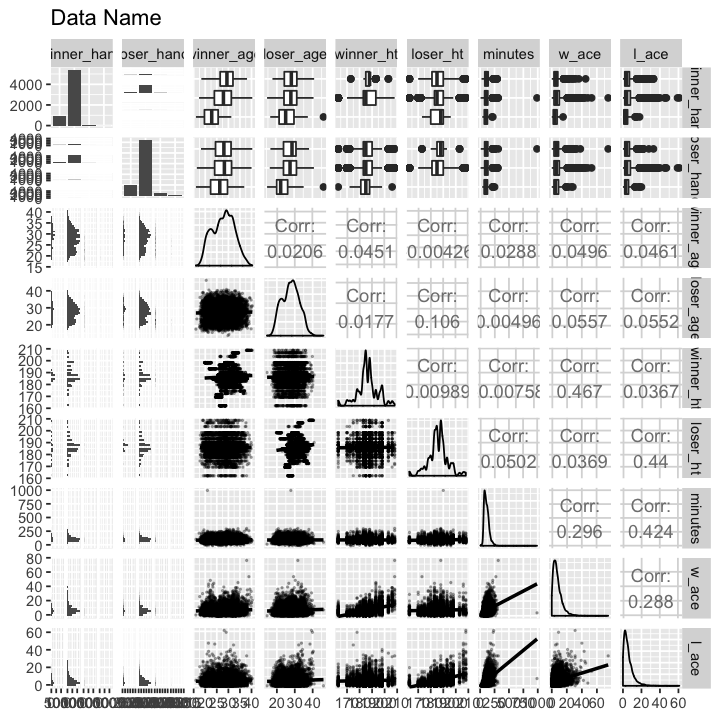

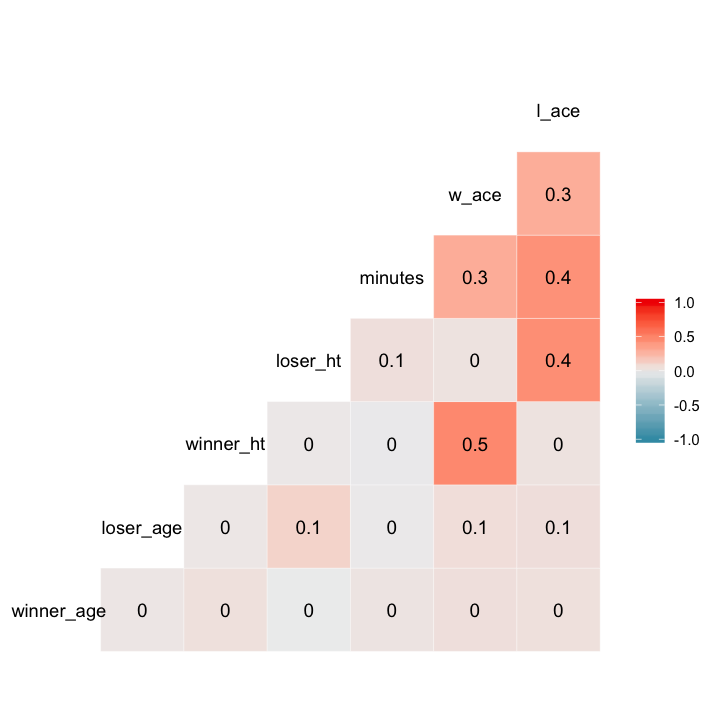

In [3]:
set.seed(42)
data2017 <- read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2017.csv', col_types = cols())
data2018 <- read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2018.csv', col_types = cols())
data2019 <- read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2019.csv', col_types = cols())

combined_data <- rbind(data2017, data2018, data2019)

tennis <- combined_data %>% 
    select(winner_hand, loser_hand, winner_age, loser_age, winner_ht, loser_ht, minutes, w_ace, l_ace)

tennis_win = select(tennis, winner_hand, winner_age, winner_ht, minutes, w_ace)
tennis_loss = select(tennis, loser_hand, loser_age, loser_ht, minutes, l_ace)

tennis_win = mutate(tennis_win, hand = winner_hand, age = winner_age, height = winner_ht, aces = w_ace, result = 'w') %>%
            select(-winner_hand, -winner_age, -winner_ht, -w_ace)
tennis_loss = mutate(tennis_loss, hand = loser_hand, age = loser_age, height = loser_ht, aces = l_ace, result = 'l') %>%
            select(-loser_hand, -loser_age, -loser_ht, -l_ace)

cleaned_data = rbind(tennis_win, tennis_loss)

cleaned_data = mutate(cleaned_data, result = as.factor(result))

rows = sample(nrow(cleaned_data))

cleaned_data = cleaned_data[rows, ]

head(cleaned_data)

training_rows <- cleaned_data %>%
    select(result) %>% 
    unlist() %>%
    createDataPartition (p = 0.75 , list = FALSE)

training_set <- tennis %>% slice (training_rows)
testing_set <- tennis %>% slice (-training_rows)


tennis_plots <- ggpairs(training_set, label = TRUE, title = "Data Name", lower = list(continuous = wrap("smooth", alpha = 0.3, size=0.3)))
tennis_matrix <- ggcorr(training_set, label = TRUE, title = "Data Name")
options (repr.plot.width=6, repr.plot.height=6)

tennis_plots
tennis_matrix

There are two goals we want to achieve with our visualization:
- The correlation between our predicting variables. If there is one variable highly correlated to another, we might eliminate them and simplify the modelling process
- The correlation between our predicting variables with our labeling variables
We achieve this by using ggpair() and ggcorr() functions. While ggpair() gives us a comprehensive view of how each variable correlates to each other through histograms, box plots, regression model and more, ggcorr() provides a more straightforward matrix with results of correlation between variables.

# Methods

In order to wrangle our data, we have to use the read_csv() function on the raw links to the data on: https://github.com/JeffSackmann/tennis_atp. Because we are looking across three years of data we read 3 files and combine them using the rbind() function. Cleaning the data involved separating the winners and losers, creating a new result column, and then recombining them into one cleaned data set.

For classification analysis we will be using the following columns:

* item winner_hand (the dominant hand of the winner)
* item loser_hand (the dominant hand of the loser)
* item winner_age 
* item loser_age
* item winner_ht (the height of the winner)
* item loser_ht (the height of the loser)
* item minutes (The length of the match)
* item w_ace (number of aces the winner had)
* item l_ace (the number aces the loser had)

and creating a knn-model in order to classify a whether or not a hypothetical player with given attributes will be able to win their match. We will be removing the left over columns from the set as they are not variables of interest for this analysis.

A visualisation we will create is a plot of height versus aces and colour the points by whether they were wins or losses.

# Expected outcomes and significance

With this data anaylsis we expect to find that certain attributes will be more positively correlated with successful match outcomes. For example - and increase in player height may correlate with the number of aces a player gets in a match which may in turn result in greater player success. In general we expect to find some attributes that contribute to success and others that may do the opposite. These findings could help in the scouting of new tennis player talent for sponsorships by companies that make tennis gear. For example if a new player enters the scene with a plethora of attributes that contribute positively to a players success a company may want to get in on the ground floor sponsoring them at a lower price and getting greater value out of their sponsorship spending rather than spending sponsorship dollars on already successful players who start at a higher price. Future questions that this analysis could lead to is an examination as to why certian attributes contribute to success. For example if there is an ideal range of height for a pro player - why are the heights within that range ideal? 